In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from PIL import ImageFile
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Using TensorFlow backend.


In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], False)


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12804844060544574859
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2931392508
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16341832318419729206
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


**EDA**

In [3]:
#Access the dataset

train_dir = 'C:\\Users\\Marci\\Recycle_data\\TRAIN'
validation_dir = 'C:\\Users\\Marci\\Recycle_data\\TEST'

num_of_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
num_of_test_samples = sum([len(files) for r, d, files in os.walk(validation_dir)])

print("nr of train images: " + str(num_of_train_samples))
print("nr of test images: " + str(num_of_test_samples))

nr of train images: 22564
nr of test images: 2513


In [4]:
#Standardize the data and Data augmentation

#resize your images to a consistent shape img_width, img_height = 224, 224
img_width, img_height = 224, 224
batch = 32

#below in ImageDataGenerator Data Augmentation steps are performed
#resize your images to a consistent shape img_width, img_height = 224, 224
#Rescale pixel values.The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. 
#Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.
#There are also additional visual enchacements to our pictures such as but not limited to horizon flips.
#This prevents overfitting

datagen = ImageDataGenerator(rescale=1./255 
                              ,rotation_range=45,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest'
                            )

validation_datagen = ImageDataGenerator(rescale=1./255)

#Creating our datasets

# .flow_from_directory automagically retrieve images and their classes for train and validation sets

###.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
###This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
###.prefetch() overlaps data preprocessing and model execution while training. 

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=batch,
        class_mode='binary',
        shuffle=True,
        )

validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=batch,
        class_mode='binary', 
        shuffle=True)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


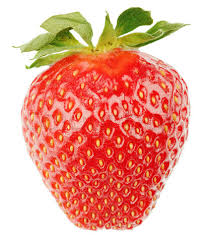

In [5]:
import PIL 
from pathlib import Path

Organic = list(Path(train_dir).glob('O/*'))
PIL.Image.open(str(Organic[0]))

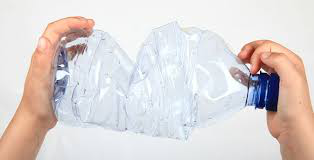

In [6]:
import PIL 
from pathlib import Path

Organic = list(Path(train_dir).glob('R/*'))
PIL.Image.open(str(Organic[0]))

**Important Note**

Normally data augmentation occurs synchronously at Layer level in the CNN in order to take advantage of GPU aceleration.
However in this case GPU is a bottleneck (only 6gb of memory in laptop GPU which additionally overheats quite fast).
Because of this, the data augmentation occurs at the dataset/image input stage and instead runs asynchronously on the CPU.

Nonetheless there are other adavantages from doing data augmentation at Layers Level (particularly with tensorflow):
Explaining the previous sentence, when you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

1.0


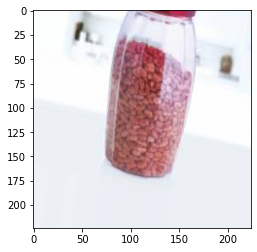

0.0


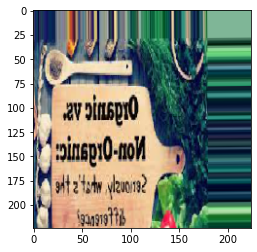

0.0


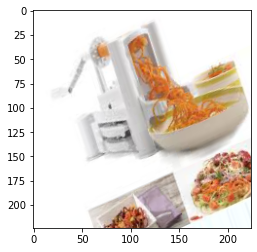

In [7]:
#Visualize the standardized and augmented data

from keras.preprocessing import image
import matplotlib.pyplot as plt

x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [8]:
nb_epoch = 10
steps_per_epoch = int(num_of_train_samples/batch)
validation_steps = int(num_of_test_samples/batch)

In [9]:
from tensorflow.keras.applications import NASNetMobile

def build_model(num_classes):
    base_model = NASNetMobile(weights='imagenet', include_top=False)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) #TODO: use leakyRelu instead of Relu
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
        
    return model


model = build_model(num_classes=2)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
reduction_right5_reduce_8 (MaxP (None, 7, 7, 176)    0           reduction_pad_1_reduce_8[0][0]   
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 15, 15, 528)  0           adjust_relu_1_9[0][0]            
__________________________________________________________________________________________________
reduction_add3_reduce_8 (Add)   (None, 7, 7, 176)    0           reduction_left3_reduce_8[0][0]   
                                                                 separable_conv_2_bn_reduction_rig
__________________________________________________________________________________________________
add_3 (Add)                     (None, 7, 7, 176)    0           reduction_add_2_reduce_8[0][0]   
                                                                 reduction_left4_reduce_8[0][0]   
__________

In [10]:
model.compile(loss='binary_crossentropy', #categorical_crossentropy for multiple classes
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
#!nvidia-smi 
#sanity check for possible GPU processes runninng in the backgorund

In [12]:
from datetime import datetime

start = datetime.now()

In [13]:
PATIENCE = 3
MODEL_CHECK_WEIGHT_NAME = 'resnet_monki_v1_chk.h5'

es_callback = EarlyStopping(monitor='accuracy', patience=PATIENCE, mode='max')
mc_callback = ModelCheckpoint(filepath=MODEL_CHECK_WEIGHT_NAME, monitor='accuracy', save_best_only=True, mode='max')

train_history = model.fit(train_generator, 
                        steps_per_epoch=len(train_generator),                                     
                        epochs= nb_epoch, validation_data=train_generator, 
                        validation_steps=len(validation_generator), 
                        verbose=1
                        ,callbacks=[es_callback, mc_callback]
                                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 706 steps, validate for 79 steps
Epoch 1/10
706/706 [==============================] - 456s 646ms/step - loss: 0.2641 - accuracy: 0.8929 - val_loss: 0.2507 - val_accuracy: 0.9011
Epoch 2/10
706/706 [==============================] - 287s 407ms/step - loss: 0.2201 - accuracy: 0.9155 - val_loss: 0.1996 - val_accuracy: 0.9225
Epoch 3/10
706/706 [==============================] - 285s 404ms/step - loss: 0.1947 - accuracy: 0.9228 - val_loss: 0.2341 - val_accuracy: 0.9023
Epoch 4/10
706/706 [==============================] - 314s 444ms/step - loss: 0.1892 - accuracy: 0.9256 - val_loss: 0.1827 - val_accuracy: 0.9288
Epoch 5/10
706/706 [==============================] - 304s 431ms/step - loss: 0.1785 - accuracy: 0.9315 - val_loss: 0.1897 - val_accuracy: 0.9205
Epoch 6/10
706/706 [==============================] - 284s 402ms/step - loss: 0.1709 - accuracy: 0.9324 - val_loss: 0.1823 - val_accuracy: 0.9276
Epoch 7/10
706/706 [===========

In [14]:
end = datetime.now()
print(end-start)

0:50:09.056487


In [15]:
print(end-start)

0:50:09.056487


In [16]:
#Leaky Relu
#https://adventuresinmachinelearning.com/vanishing-gradient-problem-tensorflow/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


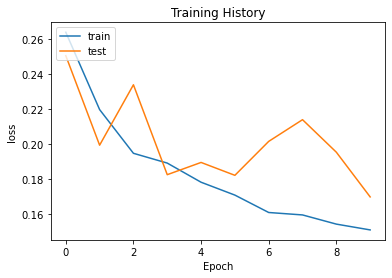

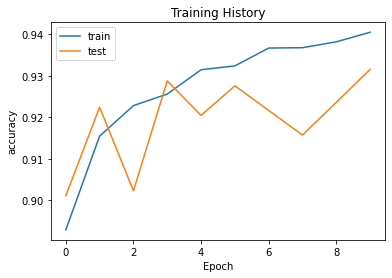

In [17]:
# Show Train History
keys= train_history.history.keys()
print(keys)

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'accuracy', 'val_accuracy')

Load the best weights

In [18]:
results = model.load_weights(MODEL_CHECK_WEIGHT_NAME)

In [19]:
results = model.load_weights(MODEL_CHECK_WEIGHT_NAME)
score = model.evaluate(validation_generator, verbose=2)
print("test loss, test acc:", score)

  ...
    to  
  ['...']
79/79 - 37s - loss: 0.3258 - accuracy: 0.8723
test loss, test acc: [0.32580603819481935, 0.8722642]


Print validation confusion matrix, classification report, and accuracy

In [20]:
predict = model.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)
test_labels = validation_generator.classes

Instructions for updating:
Please use Model.predict, which supports generators.
79/79 [==============================] - 30s 382ms/step


Text(0.5, 17.25, 'Predicted label')

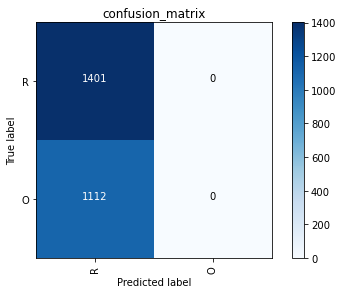

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix = confusion_matrix(test_labels.astype(np.int), predict.astype(np.int))

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['R','O'], rotation=90)
plt.yticks(tick_marks, ['R','O'])
#Following is to mention the predicated numbers in the plot and highligh the numbers the most predicted number for particular label
thresh = confusion_matrix.max() / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, confusion_matrix[i, j],
    horizontalalignment="center",
    color="white" if confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')

plt.xlabel('Predicted label')

In [22]:
cr_labels = list(validation_generator.class_indices.keys())
classification_report(test_labels, predict.argmax(axis=1), target_names=cr_labels)

C:\Users\Marci\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           O       0.56      1.00      0.72      1401\n           R       0.00      0.00      0.00      1112\n\n    accuracy                           0.56      2513\n   macro avg       0.28      0.50      0.36      2513\nweighted avg       0.31      0.56      0.40      2513\n'

In [23]:
accuracy_score(test_labels,predict.argmax(axis=1)) #review this function

0.5575009948269001

In [24]:
model.evaluate(validation_generator)

  ...
    to  
  ['...']
79/79 [==============================] - 27s 336ms/step - loss: 0.3326 - accuracy: 0.8723


[0.3325536304825469, 0.8722642]

In [25]:
import keras
keras.backend.clear_session()